In [26]:
!pip install matplotlib

In [27]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [31]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'things', 'they', 'carried', 'first', 'lieutenant_jimmy_cross', 'carried', 'letters', 'from', 'girl', 'named', 'martha', 'junior', 'at', 'mount_sebastian', 'college', 'in', 'new', 'jersey']


In [16]:
from nltk import sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cole\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cole\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
text = 'E:\\Main\\Programming\\tttc_topicanalysis\\DATA\\tttc_scrape.txt'
data = ""
with open(text, "r") as f:
    data = f.read().replace('\n', '')

In [18]:
data = sent_tokenize(data)

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [28]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'things', 'they', 'carried', 'first', 'lieutenant', 'jimmy', 'cross', 'carried', 'letters', 'from', 'girl', 'named', 'martha', 'junior', 'at', 'mount', 'sebastian', 'college', 'in', 'new', 'jersey']]


In [32]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [37]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'carry', 'first', 'lieutenant_jimmy', 'cross', 'carry', 'letter', 'girl', 'name', 'martha', 'junior', 'mount_sebastian', 'college', 'new', 'jersey']]


In [38]:
print(data_lemmatized[19])

['necessity', 'sop', 'carry', 'steel', 'helmet', 'weighed_pound', 'include', 'lin', 'camouflage', 'cover']


In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [40]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('carry', 2),
  ('college', 1),
  ('cross', 1),
  ('first', 1),
  ('girl', 1),
  ('jersey', 1),
  ('junior', 1),
  ('letter', 1),
  ('lieutenant_jimmy', 1),
  ('martha', 1),
  ('mount_sebastian', 1),
  ('name', 1),
  ('new', 1),
  ('thing', 1)]]

In [41]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [51]:
# Print the Keyword in the 20 topics
#print(lda_model.print_topics())
doc_lda = lda_model[corpus]
print(doc_lda)

In [43]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)


Perplexity:  -19.88565483535661
Coherence Score:  0.40858035097498224


In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

e:\users\cole\anaconda3\envs\tttc_litanalysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [74]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os

os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet' # update this path

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [75]:

# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('man', 0.17220801364023872),
   ('young', 0.04603580562659847),
   ('soldier', 0.043478260869565216),
   ('morning', 0.043478260869565216),
   ('weapon', 0.023017902813299233),
   ('jimmy_cross', 0.01619778346121057),
   ('tongue', 0.014492753623188406),
   ('care', 0.014492753623188406),
   ('shrug', 0.01278772378516624),
   ('check', 0.011935208866155157)]),
 (1,
  [('guy', 0.08527131782945736),
   ('happen', 0.05426356589147287),
   ('lie', 0.04995693367786391),
   ('listen', 0.04306632213608958),
   ('rain', 0.03962101636520241),
   ('sleep', 0.030146425495262703),
   ('week', 0.029285099052540915),
   ('hey', 0.023255813953488372),
   ('vietnam', 0.02153316106804479),
   ('light', 0.01808785529715762)]),
 (2,
  [('thing', 0.14145543744889616),
   ('feel', 0.13164349959116925),
   ('bad', 0.0482420278004906),
   ('inside', 0.04088307440719542),
   ('start', 0.04088307440719542),
   ('rat', 0.039247751430907606),
   ('cold', 0.01553556827473426),
   ('cool', 0.0147179067865

In [76]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [77]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


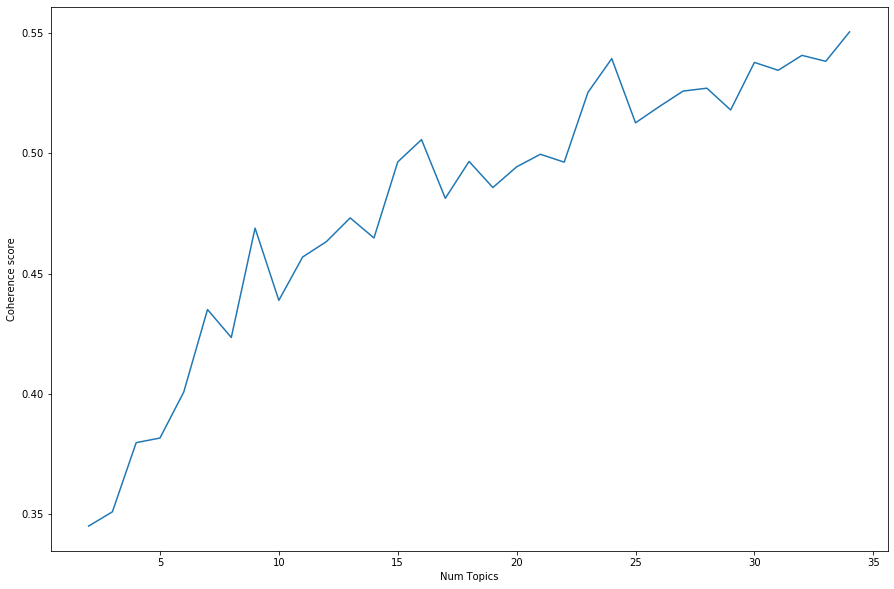

In [83]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [84]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.344839
Num Topics = 3  has Coherence Value of 0.350791
Num Topics = 4  has Coherence Value of 0.379577
Num Topics = 5  has Coherence Value of 0.381501
Num Topics = 6  has Coherence Value of 0.400626
Num Topics = 7  has Coherence Value of 0.435
Num Topics = 8  has Coherence Value of 0.423365
Num Topics = 9  has Coherence Value of 0.468901
Num Topics = 10  has Coherence Value of 0.43883
Num Topics = 11  has Coherence Value of 0.456868
Num Topics = 12  has Coherence Value of 0.463279
Num Topics = 13  has Coherence Value of 0.473159
Num Topics = 14  has Coherence Value of 0.464802
Num Topics = 15  has Coherence Value of 0.496454
Num Topics = 16  has Coherence Value of 0.505747
Num Topics = 17  has Coherence Value of 0.481326
Num Topics = 18  has Coherence Value of 0.496663
Num Topics = 19  has Coherence Value of 0.485804
Num Topics = 20  has Coherence Value of 0.494401
Num Topics = 21  has Coherence Value of 0.499661
Num Topics = 22  has Coherence V

In [85]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 14
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)

In [93]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1946,"move, find, river, place, small, lake, village...","On the lake side of the road, where real estat..."
1,1.0,0.1640,"talk, good, happen, stare, listen, write, soft...","As a starting point, maybe, Norman Bowker migh..."
2,2.0,0.1623,"make, sound, white, girl, fire, martha, quick,...","A dark theater, he remembered, and the movie w..."
3,3.0,0.1845,"guy, dead, die, kind, arm, people, understand,...","â€” and it was a restful, unencumbered sensati..."
4,4.0,0.1762,"thing, rat, smile, give, kid, mary_anne, final...",The kid's father taught Sunday school in Oklah...
5,5.0,0.1854,"time, bad, face, hard, thing, laugh, hot, ligh...","They laughed and held on tight, feeling the co..."
6,6.0,0.1524,"kiowa, body, lie, watch, rain, father, boy, wa...",He had finished writing the letter in his head...
7,7.0,0.1902,"war, story, true, life, truth, world, lose, fr...","In war you lose your sense of the definite, he..."
8,8.0,0.1996,"stop, real, tree, week, vietnam, foot, side, p...",The battalion firebase was built into a hill j...
9,9.0,0.1642,"feel, remember, inside, point, shoot, show, fo...","I remember his face, which was not a pretty fa..."


In [86]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

Perplexity:  -8.782568753305766
Coherence Score:  0.40803641980548233


e:\users\cole\anaconda3\envs\tttc_litanalysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [87]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['move', 'find', 'river', 'place', 'small', 'lake', 'village', 'walk', 'mountain', 'red']
Topic 1: ['talk', 'good', 'happen', 'stare', 'listen', 'write', 'soft', 'speak', 'crazy', 'hard']
Topic 2: ['make', 'sound', 'white', 'girl', 'fire', 'martha', 'quick', 'year', 'short', 'blame']
Topic 3: ['guy', 'dead', 'die', 'kind', 'arm', 'people', 'understand', 'burn', 'high', 'big']
Topic 4: ['thing', 'rat', 'smile', 'give', 'kid', 'mary_anne', 'finally', 'fact', 'quiet', 'bright']
Topic 5: ['time', 'bad', 'face', 'hard', 'thing', 'laugh', 'hot', 'light', 'voice', 'quietly']
Topic 6: ['kiowa', 'body', 'lie', 'watch', 'rain', 'father', 'boy', 'wait', 'letter', 'fine']
Topic 7: ['war', 'story', 'true', 'life', 'truth', 'world', 'lose', 'friend', 'pass', 'moral']
Topic 8: ['stop', 'real', 'tree', 'week', 'vietnam', 'foot', 'side', 'paddy', 'god', 'smell']
Topic 9: ['feel', 'remember', 'inside', 'point', 'shoot', 'show', 'fossie', 'pretty', 'sense', 'thought']
Topic 10: ['back', 'long', 

In [90]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.0934,"make, sound, white, girl, fire, martha, quick,...",The Things They Carried First Lieutenant Jimmy...
1,1,3.0,0.0826,"guy, dead, die, kind, arm, people, understand,...","They were not love letters, but Lieutenant Cro..."
2,2,13.0,0.1080,"night, day, sit, turn, dark, linda, hour, slee...","In the late afternoon, after a day's march, he..."
3,3,3.0,0.0958,"guy, dead, die, kind, arm, people, understand,...",He would imagine romantic camping trips into t...
4,4,3.0,0.0764,"guy, dead, die, kind, arm, people, understand,...","He would sometimes taste the envelope flaps, k..."
...,...,...,...,...,...
5252,5252,13.0,0.0826,"night, day, sit, turn, dark, linda, hour, slee...","I can see Kiowa, too, and Ted Lavender and Cur..."
5253,5253,11.0,0.0986,"man, carry, young, kill, love, ted_lavender, l...",(232) I'm young and happy.
5254,5254,3.0,0.0809,"guy, dead, die, kind, arm, people, understand,...",I'll never die.
5255,5255,7.0,0.0928,"war, story, true, life, truth, world, lose, fr...",I'm skimming across the surface of my own hist...


In [91]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [94]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [95]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,0.0,"move, find, river, place, small, lake, village, walk, mountain, red",712,0.1354
1.0,1.0,"talk, good, happen, stare, listen, write, soft, speak, crazy, hard",365,0.0694
2.0,2.0,"make, sound, white, girl, fire, martha, quick, year, short, blame",343,0.0652
3.0,3.0,"guy, dead, die, kind, arm, people, understand, burn, high, big",375,0.0713
4.0,4.0,"thing, rat, smile, give, kid, mary_anne, finally, fact, quiet, bright",351,0.0668
5.0,5.0,"time, bad, face, hard, thing, laugh, hot, light, voice, quietly",325,0.0618
6.0,6.0,"kiowa, body, lie, watch, rain, father, boy, wait, letter, fine",326,0.0620
7.0,7.0,"war, story, true, life, truth, world, lose, friend, pass, moral",305,0.0580
8.0,8.0,"stop, real, tree, week, vietnam, foot, side, paddy, god, smell",298,0.0567
9.0,9.0,"feel, remember, inside, point, shoot, show, fossie, pretty, sense, thought",302,0.0574
